# Galaxy Merger Simulation of Two Disk Galaxies
\
This program shows the user how to set up and run a simulation between two disk galaxies, and how to complete a preliminary analysis of the results. The disk galaxy models were generated using the Agama package (Vasiliev, 2018), and are in quasi-equilibrium when simulated in isolation. Due to the algorithm scaling as O(N$^2$), many of the important components found in spiral galaxies such as gas, dark matter, central black hole, and bulge were omitted, which are integral in keeping the model in equilibrium. This program simulates the interaction between a 10:1 merger of a larger galaxy and a smaller satellite galaxy in a violent collision event.

N-body simulations work by calculating the motion of each particle through time and space based on the mutual softened gravitational attraction from all the other particles in the simulation using equation (1). Thus, similarly to chaotic systems and other numerical integration problems, N-body simulations are heavily dependent on the initial conditions of the simulation. As such, most of the work in running simulations is coming up with a suitable set of initial conditions.
$$
g_{i} = -G\sum_{j\ne i}m_{j}\frac{r_{i}-r_{j}}{(|r_{i}-r_{j}|^{2} + \epsilon^{2} )^{3/2}} \qquad (1)
$$
***
Please ensure MSG_Nbody is installed via pip before running the program. 

***
## Table of Contents:
### Steps in running a simulation:
- load initial conditions and create copies for the host and satellite galaxy
- scale the positions, velocities, and masses of the host and satellite galaxy relative to each other; e.i. make the host galaxy 10x more massive
- add disk inclination if desired
- set the galaxies on a collision course
- merge the initial conditions into 3 contiguous NumPy arrays
- run the simulation and analyze the results!

In [1]:
from MSG_Nbody import *

## Loading initial conditions:
The initial conditions of the spiral galaxy have been precomputed and can be read into Python as a .txt file. Initial conditions for N-body simulations require initial positions, velocities, and masses of each particle in the simulation. For clarity, we will store each parameter in a separate array. For N particles, the position and velocity arrays should have dimensions of N x 3 (this simulation is in 3 dimensions) while masses N x 1. However, the initial conditions provided are stored in an N x 7 array $(x, y, z, v_x, v_y, v_z, m)$ and therefore need to be reshaped. The **load_initial_conditions** function does this efficiently.

In [2]:
# load in initial positions, velocities, and masses for host galaxy
host_pos, host_vel, host_mass = load_initial_conditions('Initial_Conditions/disk_galaxy_N3000')

## Scaling initial conditions
Now that the initial conditions are loaded into Python, we can scale them to create different galaxy models. For this simulation, a smaller 'satellite' galaxy will merge with a larger, more massive 'host' galaxy. The **scale_initial_conditions** function scales the positions, velocities, and masses proportioanlly such that the galaxies stay in energetic equilibrium. In this simulation, the mass ratio between the host galaxy and the satellite galaxy is ~10 : 1.

In [3]:
# scale satellite galaxy 
initial_mass = np.sum(host_mass)
# divide by the total mass to normalize the satellite galaxy mass
R = 1/initial_mass
M = 1/initial_mass
sat_pos, sat_vel, sat_mass = scale_initial_positions(host_pos, host_vel, host_mass, R, M)

# scale host galaxy initial conditions
host_pos, host_vel, host_mass = scale_initial_positions(host_pos, host_vel, host_mass, 1.0, 3.9)

print(f'final satellite disk galaxy mass: {np.sum(sat_mass)}')
print(f'final host disk galaxy mass: {np.sum(host_mass)}')

final satellite disk galaxy mass: 0.9999999999999993
final host disk galaxy mass: 10.037840201999998


## Adding disk inclination to the galaxy model
We can also rotate the disk about a specified axis using a rotation matrix, which will rotate the disk around the $x, y,$ or $z$ axis. In this example, we will rotate the satellite galaxy around the $y$ axis by 45º, and the host galaxy by -30º with the **rotate_disk** function. This function rotates the positions and velocities by a specified degree around a specified axis.

In [4]:
# rotate around y axis by 45º and -30º
sat_pos, sat_vel = rotate_disk(sat_pos, sat_vel, 45, 'y')
host_pos, host_vel = rotate_disk(host_pos, host_vel, -30, 'y')

## Set galaxies on a collision course
Both galaxies are by default located at the origin. Thus, we must move the satellite galaxy far from the host galaxy by adding the coordinates of where we want to place it to its position array. We then add a velocity vector to the velocity array of the satellite galaxy pointing in the direction of the host galaxy to set them on a collision course. This vector must be less than the escape velocity of the satellite galaxy if the two galaxies are to merge. We can calculate the escape velocity easily with the **compute_escape_velocity** function. For this simulation, we will place the satellite galaxy 40 units away in the x and y direction from the host galaxy.

In [5]:
# calculate the escape velocity of the satellite galaxy placed at x=50,y=30,z=15
P0 = [50.0, 30.0, 15.0]
escape_velocity = compute_escape_velocity(P0[0], P0[1], P0[2], np.sum(host_mass))
print(f'escape velocity: {escape_velocity}')

escape velocity: 0.5774416875391842


The magnitude of the escape velocity is ~0.58, which can be divided into $vx, vy$, and $vz$ components. To keep things simple, we will keep the host galaxy at rest and set the satellite galaxy on an elliptical orbit into the host galaxy. We can keep the host galaxy at rest if we assume we are in the frame of reference of the host galaxy.

In [6]:
V0 = [-0.25, -0.25, -0.1]
print('magnitude of satellite galaxy trajectory velocity: ', np.sqrt(V0[0]**2 + V0[1]**2 + V0[2]**2))
# move satellite galaxy to its initial position
sat_pos += P0
# give the satellite galaxy a velocity in the negative x direction less than the escape velocity to put it on a collision path
# the velocity is negative because, from the satellite galaxy, the host galaxy is in the negative x direction
sat_vel += V0
# flip the direction of rotation of the host galaxy for stronger gravitational tidal forces
host_vel = host_vel*-1

magnitude of satellite galaxy trajectory velocity:  0.3674234614174767


## Merge the arrays into master position, velocity, and mass arrays
To ensure Numba works properly, it is advantageous to create contiguous NumPy arrays which store the data in the same physical memory location on your computer for faster computation times. We can concatenate any number of arrays together with **concatenate_initial_conditions**.

In [7]:
pos_list = [host_pos, sat_pos]
vel_list = [host_vel, sat_vel]
mass_list = [host_mass, sat_mass]
positions, velocities, masses = concatenate_initial_conditions(pos_list, vel_list, mass_list)

positions shape: (6000, 3), velocities shape: (6000, 3), masses shape: (6000, 1) total simulation mass: 11.0


Printing the shape of the position, velocity, and mass arrays, we can see they are now a combination of both galaxies' initial conditions. Since each galaxy had a particle count of N = 3000, the total particle count is now 6,000. We also see the total simulation mass is 11 which makes sense since we are simulating a 10:1 merger.

## Visualizing the Orbital Trajectory
Before running an expensive simulation, it would be better to get an idea of the approximate trajectory of the galaxies. The **plot_orbital_trajectory** function simplifies each galaxy to a point mass located at their center of masses and performs a quick N-body simulation based on the initial conditions of our merger. We can then get an approximate idea of how the merger will progress by plotting the trajectories. Keep in mind this is assuming point masses and therefore once the galaxies start merging they will most likely deviate from this plotted trajectory. However, this can help you catch a silly initial condition mistake before running an expensive simulation. The final timestep is plotted with a star marker, and we can optionally plot the initial conditions with **plot_glxys**.

100%|█████████████████████████████████████| 5000/5000 [00:03<00:00, 1391.82it/s]


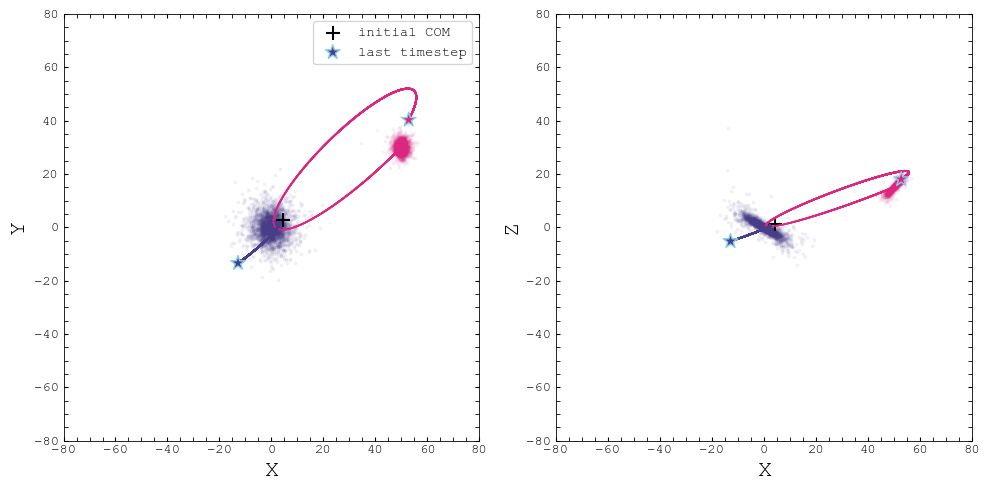

In [8]:
# display the initial simulation setup!
dt = 0.1
timesteps = 5000
init_vels = [[0,0,0], V0]
plot_orbital_trajectory(pos_list, init_vels, mass_list, dt, timesteps, scale=80, plot_glxys=True)

# Run the Simulation!
## N-body Simulation Code
The **MSG_Nbody** function is the main simulation loop which simulates our merger. At each timestep, it will call **compute_accel_potential**, the computationally heavy part of the simulation and the function responsible for computing the acceleration onto each particle. With each piece of the simulation ready, we can run the simulation and then analyze the results! This will require substantial CPU operations and RAM to run, and it is recommended that you restart your laptop before running a heavy simulation (to clear the ram), and closing all other background tasks on your computer. The code is parallelized and therefore will utilize all available CPUs on your machine! If you don't want to run the simulation on your laptop, you can alternatively download the snapshots that I precomputed on my laptop to finish the guide in the DOCUMENTATION folder.
***
This simulation took less than 7 minutes on my M2 macbook air with 8 CPUs and 16GB of RAM. The progress bar gives you a good estimate of the remaining computation time, as well as iterations per second. There will be an initial header where the just-in-time Numba compiler precompiles the program into machine code for faster execution. After this, the progress bar should appear. The function will automatically create a unique directory to save simulation snapshots in!

In [9]:
# run N-body simulation
MSG_Nbody(positions, velocities, masses, 0.1, 2000, snapshot_save_rate=10)

simulation running....  /ᐠ –ꞈ –ᐟ\<[pls be patient]


100%|███████████████████████████████████████| 2000/2000 [06:36<00:00,  5.05it/s]

simulation complete [yay!!! =＾● ᆺ ●＾= ✿✧･ﾟ: ✧･ﾟ]


## Viewing the Simulation

##### Note: all plotting functions accept the parameter **savefig=True** to save the figure as either a png or pdf, along with the **dpi** parameter to control the figure resolution. The user will be prompted to enter the figure name (e.i. myfigure.png) along with the format (png or pdf).

##### The functions are also designed to take any number of galaxies, and have a predefined sequence of colors for the plots. If the number of galaxies exceed the number of defined colors, the plots will fallback to the matplotlib cmap rainbow. To change this, you can modify the sequence of colors in the **set_plot_colors** source code. 
***
To load simulation snapshots back into python, use the **load_simulation_outputs** function. This will create subarrays for each galaxy and load each timestep into the appropriate subarrays. Each returned object (positions, velocities, & masses) is a list of len(N_per_galaxy) containing the separated position, velocity, and potential array of each galaxy. The parameter **N_per_galaxy** is a list specifying the number of particles per galaxy. The arrays each have shapes TxNx3 for positions and velocities, and TxNx1 for masses, where T is the number of timesteps. In this simulation, each galaxy has N=3000, thus N_per_galaxy = [3000, 3000]. The analysis suite has been designed to accept the data structure returned by **load_simulation_outputs** for convenience. To load the timesteps, specify the path to where the snapshots are located using the structure: **path_2_folder/$*$**, where the **$*$** tells the function to load every snapshot inside the directory.

In [3]:
directory = 'simulation_outputs_N6000_documentation/*'
N_per_galaxy = [3000, 3000]
positions, velocities, potentials = load_simulation_outputs(directory, N_per_galaxy)

100%|███████████████████████████████████████| 201/201 [00:00<00:00, 4272.14it/s]


The first thing we might want to do is see an overview of the simulation at various timesteps. The **plot_hexpanel** and **plot_panel** functions will graph 9 timesteps simultaneously by default between t=0 and the last simulation timestep. We can change the number of rows and columns with **nrows_ncols**. With the **axes** parameter, we specify which projection to plot, where 0→X, 1→Y, and 2→Z. We can change the color and cmaps of a plot with **user_colors** and **user_cmaps**.

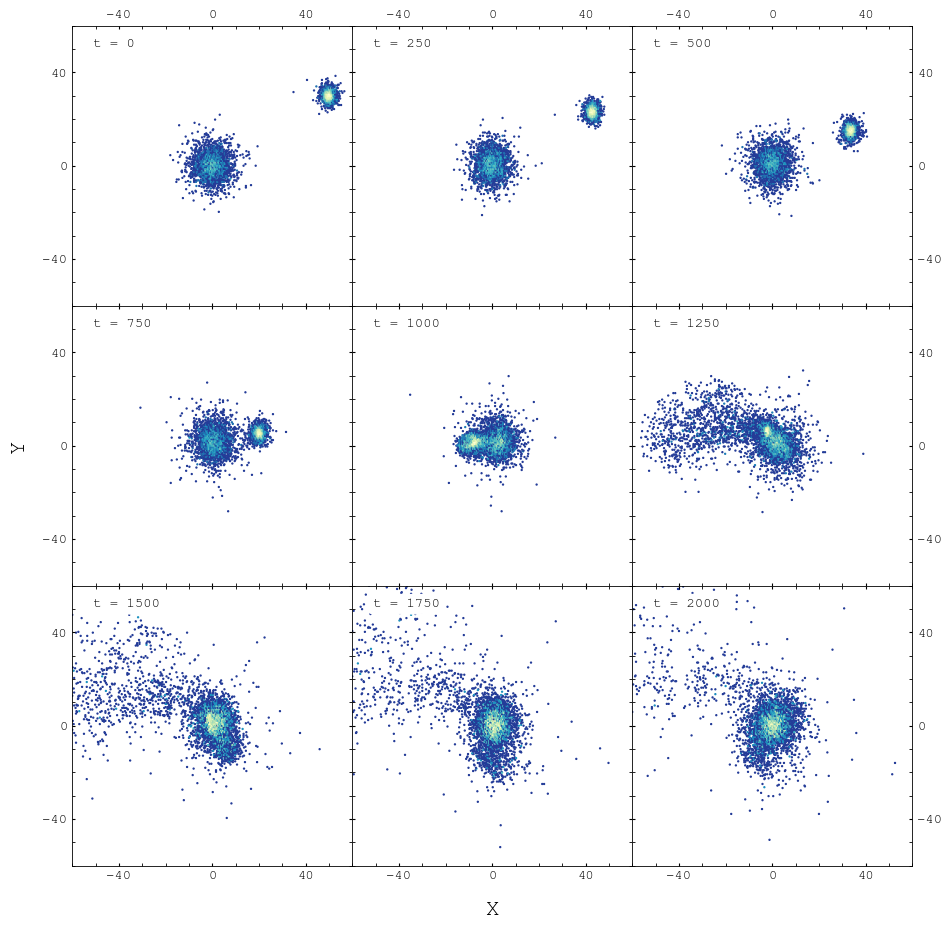

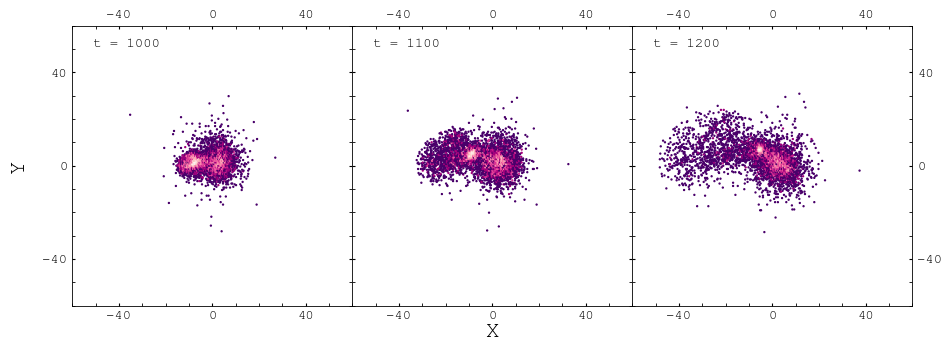

In [9]:
axes = [0,1]
scale = 60

plot_hexpanel(positions, axes, scale=scale)

t = [100, 110, 120]
nrows_ncols = [1,3]
plot_hexpanel(positions, axes, timesteps=t, scale=scale, nrows_ncols=nrows_ncols, user_cmaps=['RdPu_r'])

The **sort** parameter sorts the particles by the dimension not plotted, meaning for the XY projection, the function sorts by the Z height. By default, this is True for all scatter plots. This ensures that the height of the particles are considered when creating the 2D projection. Below we plot the XZ projection, sorted by the Y height.

sort = True


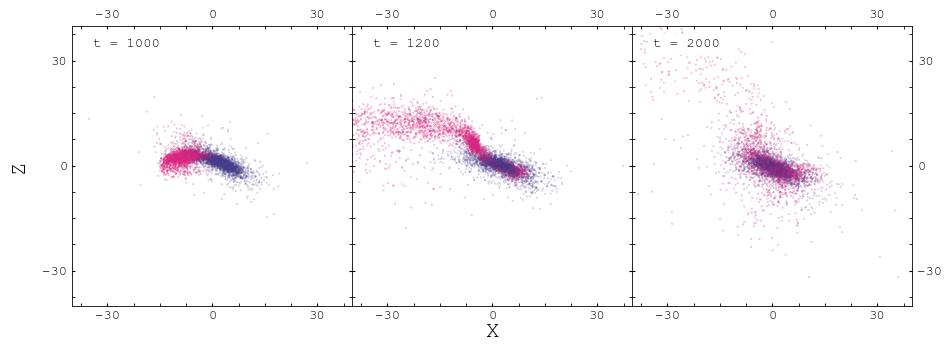

sort = False


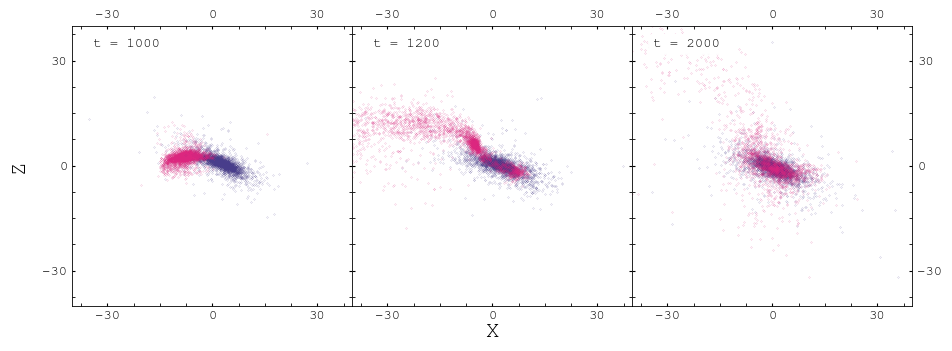

In [12]:
axes = [0,2]
nrows_ncols = [1,3]
t = [100, 120, 200]
print('sort = True')
plot_panel(positions, axes, timesteps=t, nrows_ncols=nrows_ncols, scale=40, s=0.01)
print('sort = False')
plot_panel(positions, axes, timesteps=t, nrows_ncols=nrows_ncols, scale=40, s=0.01, sort=False)

## Using a Cmap
We can map a galaxy's color to an array in the many of the plotting functions, including **plot_panel**, **plot_2D**, **plot_3D**, and **plot_density_histogram**. Here we map the galaxy to its velocity magntude at the particular timestep we are plotting. The **cmap** argument takes in a dictionary where the key is the index of the galaxy in the 'positions' list while the value is the array to be used in the cmap. If the positions array inside the 'positions' list has shape TxNx3, ensure that the array used in the cmap dictionary has shape TxN. The **cb_idx** parameter controls which key-value pair is used for the colorbar. By default is set to 0, and corresponds to the first key-value pair, while subsequent increments (e.i. cb_idx=1) correspond to the next key-value pair.

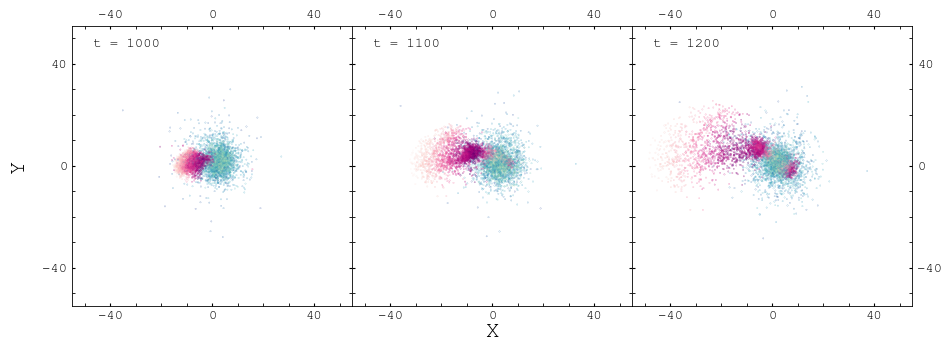

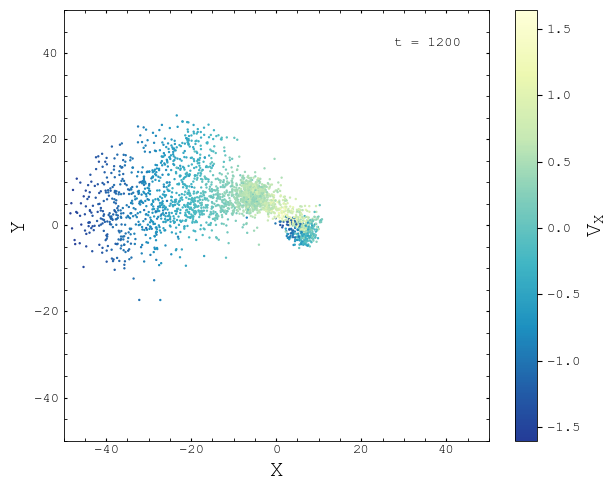

In [25]:
t = [100, 110, 120]
axes = [0,1]

# v_gal is a (timestep x N) array of velocity magnitudes
v_gal1 = compute_magnitude(velocities[0])
v_gal2 = compute_magnitude(velocities[1])
# create cmap dict
cmap_dict_v = {0:v_gal1, 1:v_gal2}

# Velocity Magnitude
plot_panel(positions, axes, timesteps=t, scale=55, s=0.01, nrows_ncols=[1,3], cmap_dict=cmap_dict_v)

v_gal2x = velocities[1][:,:,0]
# now with only 1 galaxy, "galaxy2's" index is 0 instead of 1
cmap_dict_vx = {0:v_gal2x}

# X Velocity Component
plot_2D([ positions[1] ], 120, axes, cmap_dict=cmap_dict_vx, sort=False, cb_label=r'$V_{X}$') 

## Shifting to a COM Frame & Density Histograms
You might have noticed that the galaxies drift throughout the simulation, and are not centered in the plot. We can shift to the center of mass frame of the simulation or of a certain galaxy with the **shift_2_com_frame** function. The global center of mass frame will subtract the COM of all particles from each galaxy, such that the COM is centered at the origin. Alternatively, use the **galaxy_idx** parameter to shift to a galaxy COM frame, ensuring a specific galaxy is always centered at the origin. This corresponds the index of the galaxy in the positions list, and the provided masses should be the masses of that galaxy alone. We can then plot the particles along with log density histograms of their spatial distribution using **plot_density_histogram**.

shifting frame of reference: 100%|██████████| 201/201 [00:00<00:00, 3441.66it/s]


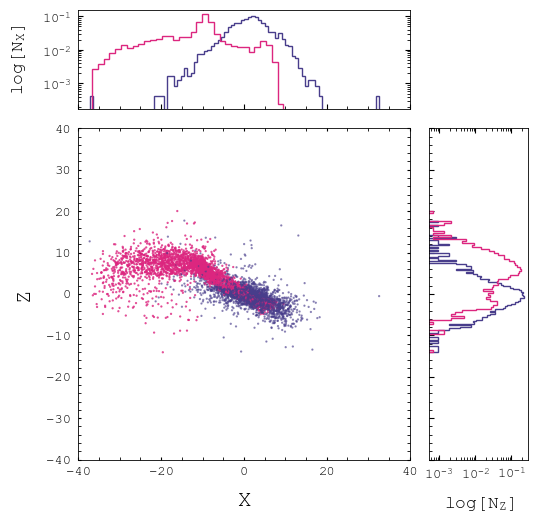

In [13]:
# shift to global center of mass frame
positions, velocities = shift_2_com_frame(positions, velocities, masses)

t = 112
plot_density_histogram(positions, t, [0,2], scale=40)

shifting frame of reference: 100%|██████████| 201/201 [00:00<00:00, 4478.52it/s]


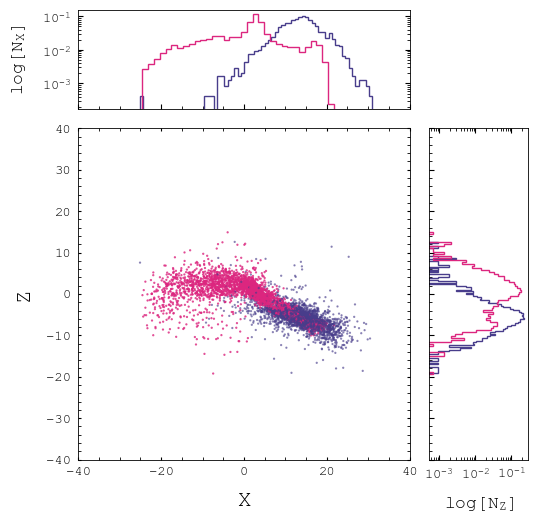

In [14]:
# shift to center of mass frame of satellite galaxy

positions, velocities = shift_2_com_frame(positions, velocities, sat_mass, galaxy_idx=1)
t = 112
plot_density_histogram(positions, t, [0,2], scale=40)

## Position-Velocity Diagrams
To compare simulated data to observational data, it is helpful to create simulated position-velocity diagrams. We can choose any line of sight vector to project the particles onto the plane orthagonal to this vector, and then plot the line of sight velocity as a function of the major axis positions. We choose a galaxy to plot at a timestep of interest, and choose a line of sight vector **line_of_sight** = [x,y,z]. This vector will automatically be converted to a unit vector. The **width** parameter controls the half-width of the cross section slice chosen.

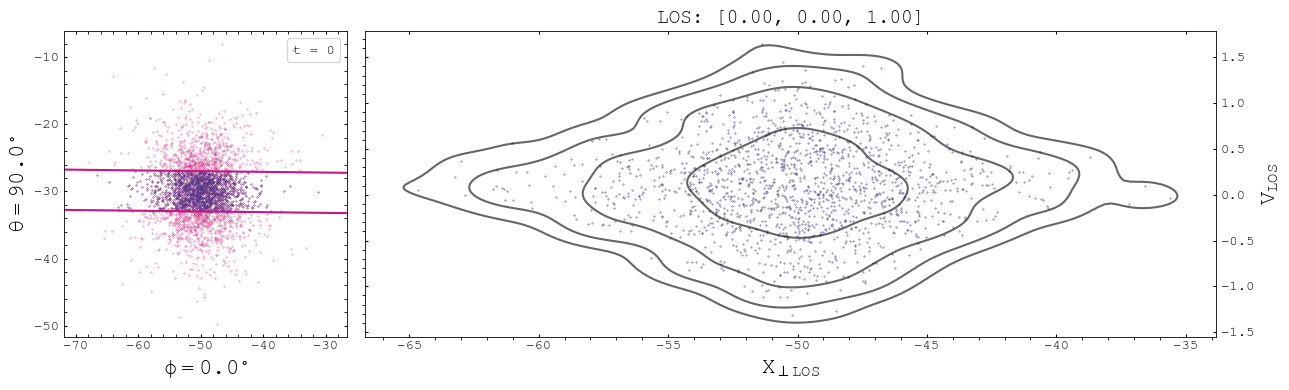

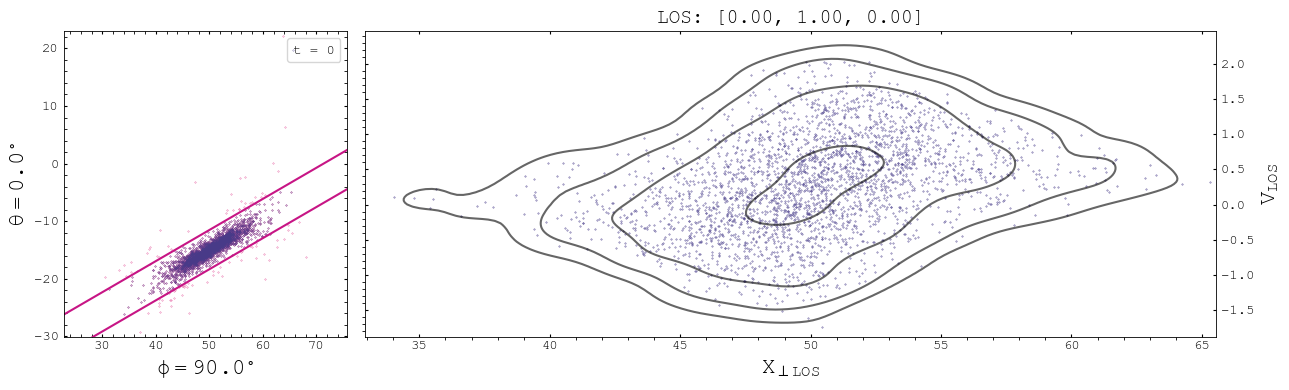

In [15]:
gal1_pos = positions[0]
gal1_vel = velocities[0]
# z axis los vector (xy projection)
t = 0
los_vector = [0,0,1]
width = 3
plot_PVD(gal1_pos, gal1_vel, t, los_vector, width)

# y axis los vector (xz projection)
los_vector = [0,1,0]
plot_PVD(gal1_pos, gal1_vel, t, los_vector, width)

The **plot_PVD** function fits a linear polynomial $y=mx+b$ to the data to determine the cross section. Although convinient, this might not be the optimal best fit for a given timestep. The user can shift the cross section using the **m_shift** and **b_shift** parameters, which will scale the line of best fit as follows: $y' = m*m_{shift}+b+b_{shift}$. If the line is near-vertical, it is optimal to pass in **transpose=True** which will plot the line of sight velocity as a function of the minor axis position rather than the major axis.

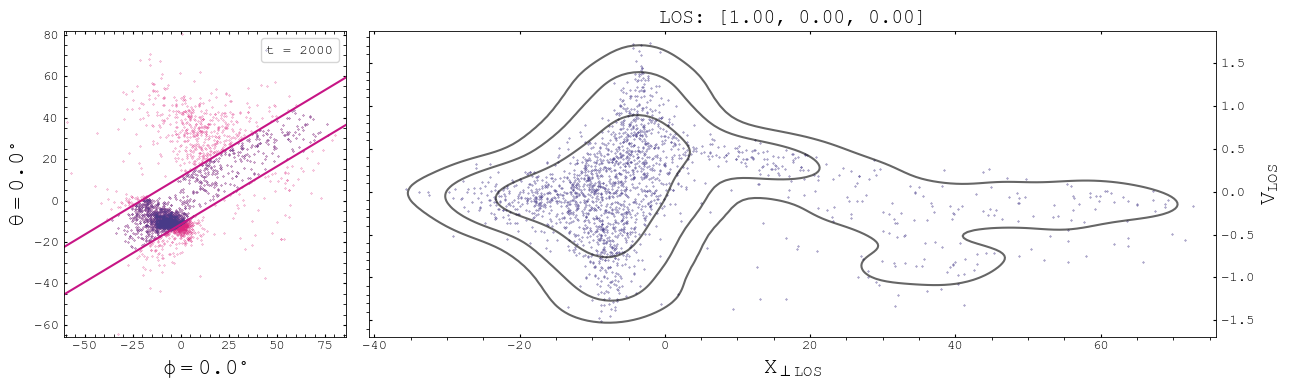

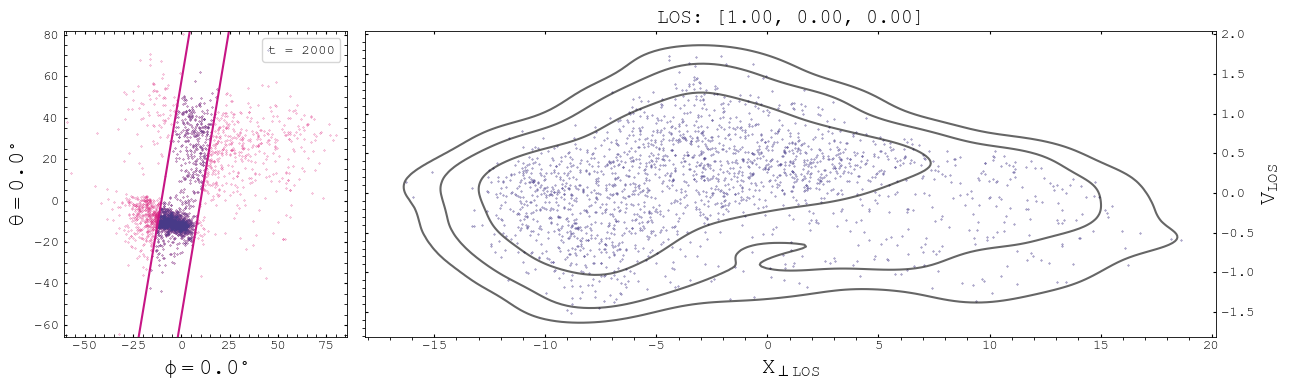

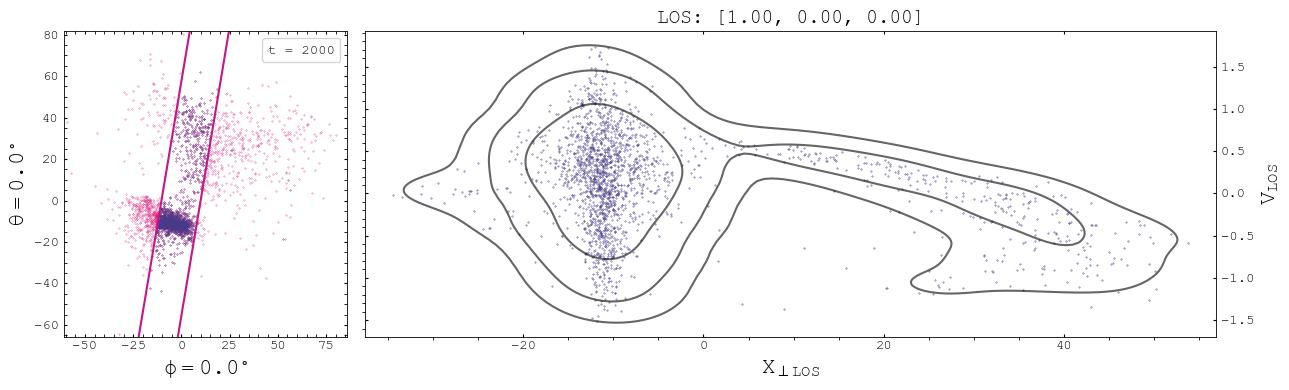

In [16]:
gal2_pos = positions[1]
gal2_vel = velocities[1]
# z axis los vector (xy projection)
t = 200
los_vector = [1,0,0]
width = 10

# default m and b values
plot_PVD(gal2_pos, gal2_vel, t, los_vector, width)

# shift line of best fit to include more particles
plot_PVD(gal2_pos, gal2_vel, t, los_vector, width, m_shift=10, b_shift=1)

# with transpose = True, we now plot the positions along the 'y' axis instead of along the 'x' axis
# which shows the best PVD for the timestep
plot_PVD(gal2_pos, gal2_vel, t, los_vector, width, m_shift=10, b_shift=1, transpose=True)

## Plotting Energies
To plot Energies, we can compute the relative energy of each galaxy using the **compute_relative_energy** function. This returns a list of arrays where each array is a TxNx1 array of energies for each galaxy. To plot the distribution of energies of a galaxy at specific timesteps, use the **plot_Ne** function. The parameters **bin_min** and **bin_max** control the log min and max bounds [10$^{bin \ min}$, 10$^{bin \ max}$].

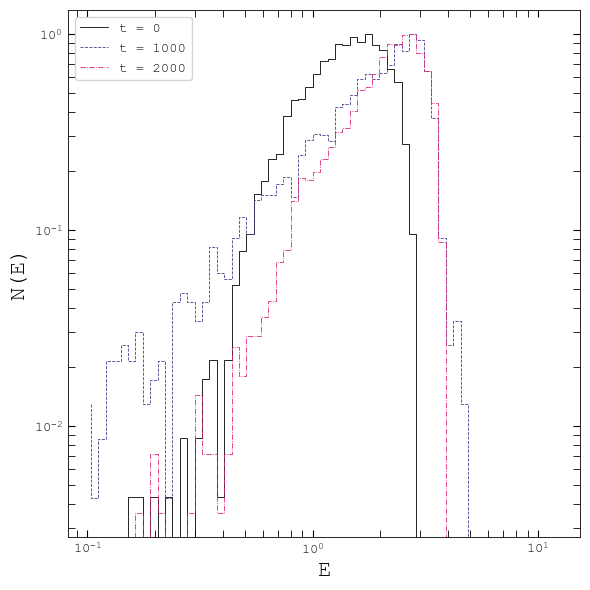

In [17]:
energies = compute_relative_energy(velocities, potentials)

# plot the energy distribution of the satelite galaxy
t = [0, 100, 200]
plot_Ne(energies[0], t, bin_min=-1, bin_max=1.1)

We can pass in any number of timesteps, here we plot all timesteps at once! The colorbar is mapped to the timestep number. We can also overplot the analytical energy distribution of a spherical galaxy, which will prompt the user to enter the Mass $M$ and scale length $\alpha$, as well as the number of particles $N$ in this theoretical spherical galaxy.

Hernquist Galaxy Params:


mass of galaxy M:  10
scale length of galaxy a:  2
number of particles N:  3000


calculating g(E): 100%|███████████████████| 4999/4999 [00:00<00:00, 5294.67it/s]


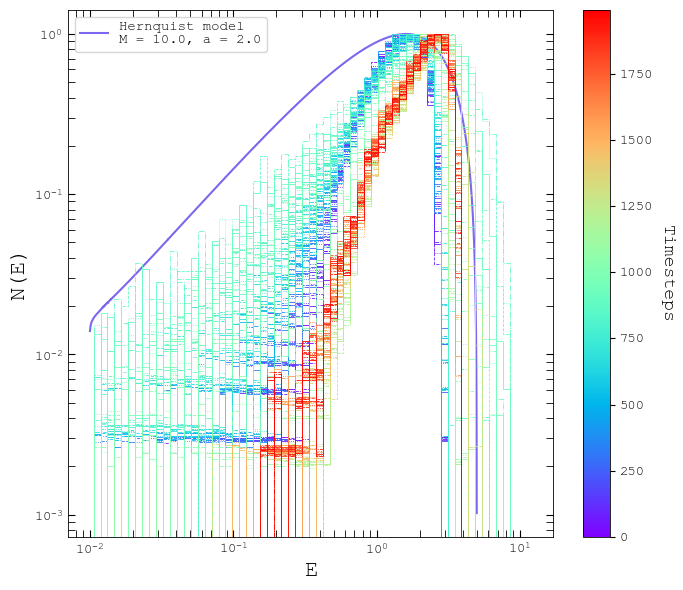

In [18]:
t = np.arange(0, 200, 1)
plot_Ne(energies[0], t, bin_min=-2, bin_max=1.1, plot_hernquist=True)

## Other Functionalities
As mentioned, we can load an arbitrary number of galaxies. You can therefore 'tag' certain particles if you know their indexes in the original conditions passed into **MSG_Nbody**. For example, we can separate our satelite galaxy into 6 subarrays. The plotting functions will then generate a unique color array from a cmap to color each galaxy with a unique color.

In [26]:
host_galaxy_N = 3000
N_per_galaxy = [host_galaxy_N, 100, 100, 100, 100, 100, 2500]
positions, velocities, potentials = load_simulation_outputs(directory, N_per_galaxy)

100%|███████████████████████████████████████| 201/201 [00:00<00:00, 3877.17it/s]


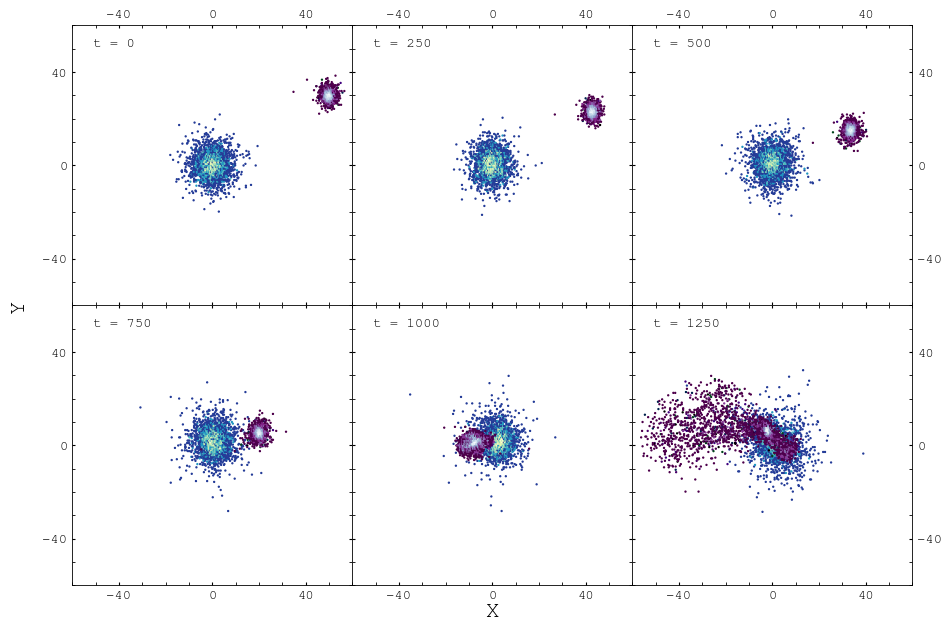

In [30]:
axes = [0,1]
scale = 60
t = [0, 25, 50, 75, 100, 125]
plot_hexpanel(positions, axes,timesteps=t, nrows_ncols=[2,3], scale=scale, sort=False)

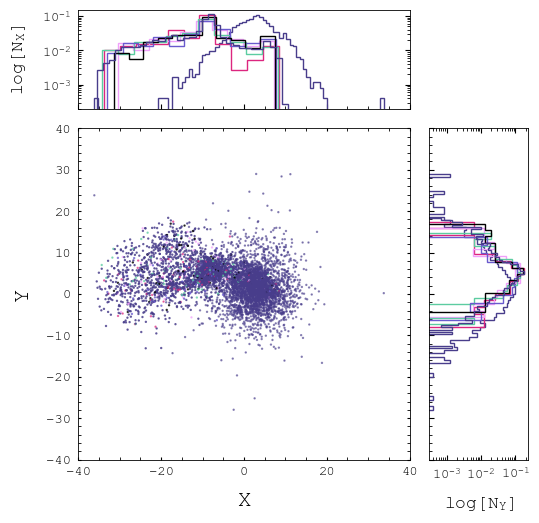

In [31]:
t = 112
plot_density_histogram(positions, t, [0,1], scale=40)

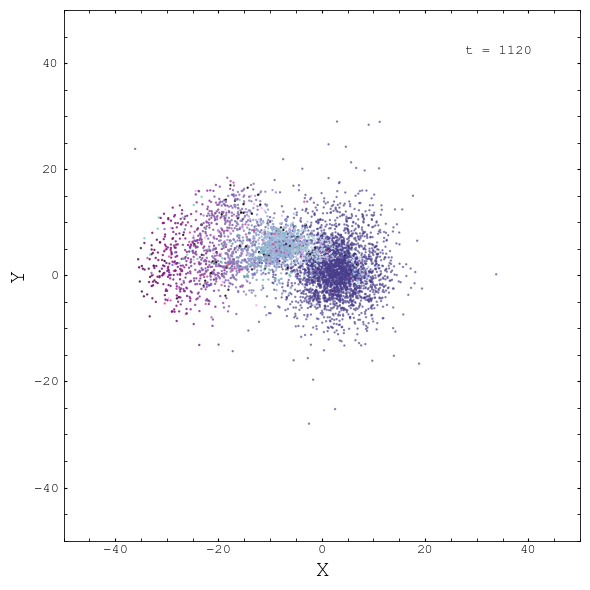

In [37]:
plot_2D(positions, 112, [0,1], cmap_dict={6: velocities[6][:,:,0]})

## Dark Mode
Finally, all plotting functions can be switched to dark mode with **dark_mode=True**.

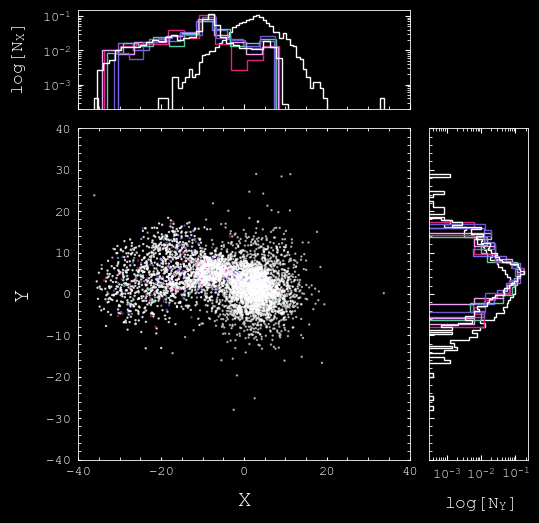

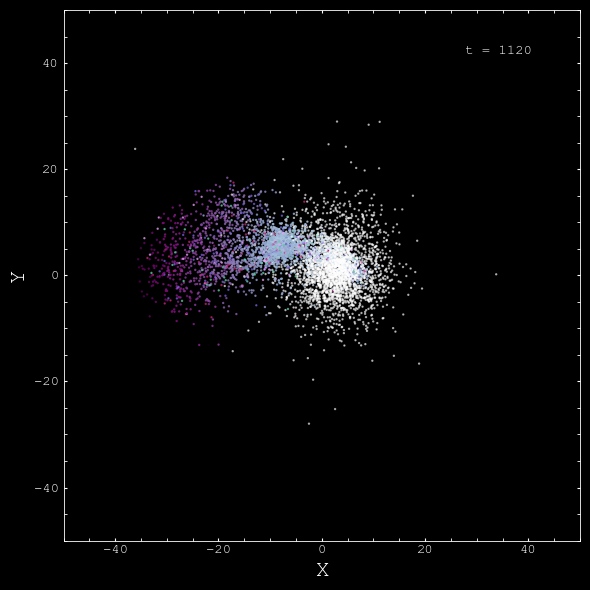

In [39]:
t = 112
plot_density_histogram(positions, t, [0,1], scale=40, dark_mode=True)
plot_2D(positions, t, [0,1], cmap_dict={6: velocities[6][:,:,0]}, dark_mode=True)

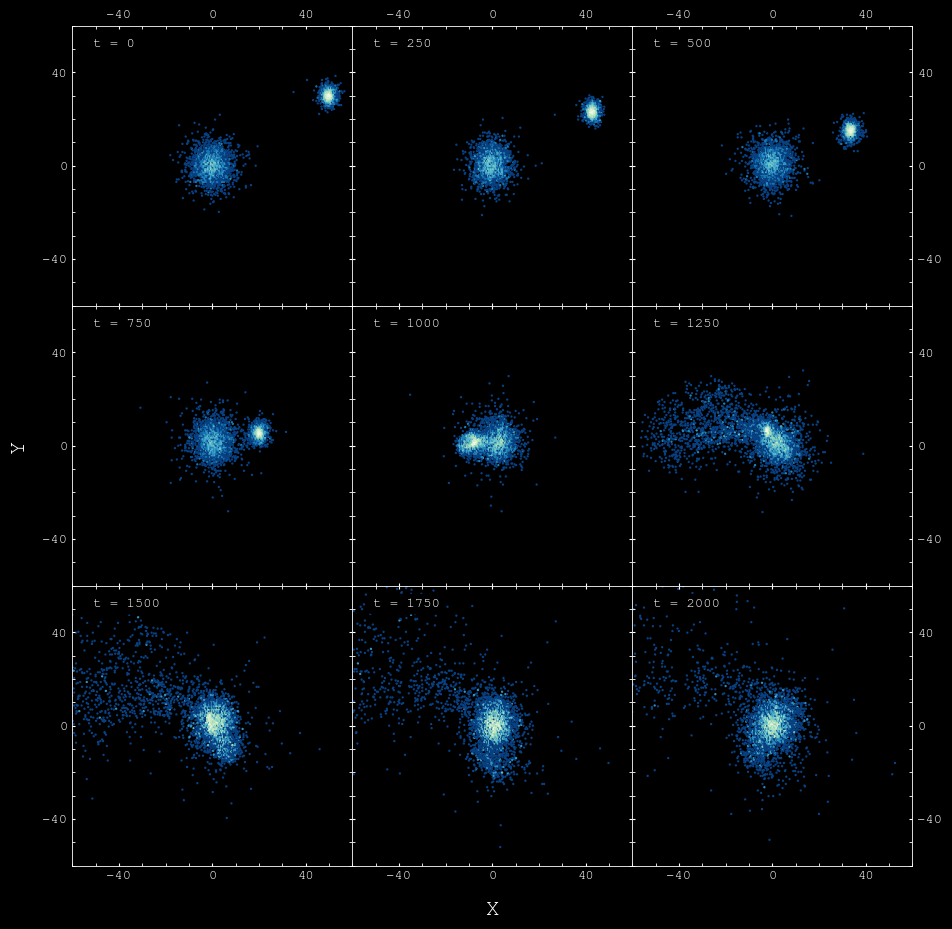

In [40]:
axes = [0,1]
scale = 60

plot_hexpanel(positions, axes, scale=scale, dark_mode=True)

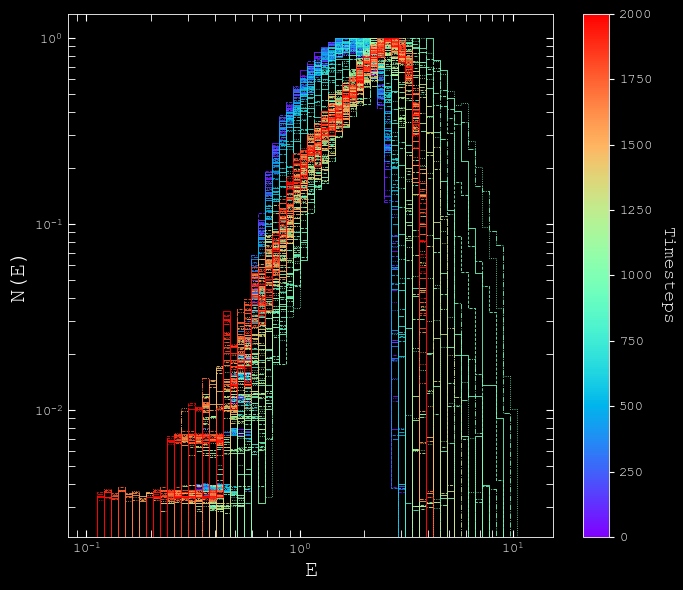

In [44]:
energies = compute_relative_energy(velocities, potentials)
t = np.arange(0, energies[0].shape[0], 1)
# plot the energy distribution of the satelite galaxy
plot_Ne(energies[0], t, bin_min=-1, bin_max=1.1, dark_mode=True)